In [36]:
#Some test to exxtract stanford dataset
#!pip install dash-leaflet
#!pip install obspy

  Using cached dash_leaflet-0.1.23-py3-none-any.whl (1.9 MB)
  Using cached geobuf-1.1.1-py3-none-any.whl (13 kB)
  Using cached protobuf-3.19.4-cp38-cp38-win_amd64.whl (895 kB)


In [37]:
import pandas as pd
import numpy as np

df_test = pd.read_csv("csvs/chunk5.csv")

df_test.set_index('trace_name',inplace= True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [38]:
min(df_test['source_distance_km'])

df_test_closest = df_test[df_test['source_distance_km'] == min(df_test['source_distance_km'])]

In [39]:
df_test_closest

,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_type,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category
trace_name,,,,,,,,,,,,,,,,,,,,,
KAN08.GS_20150408005359_EV,GS,KAN08,HH,37.22672,-97.970947,375.0,400.0,manual,0.63,0.78,...,ml,ISMP,None,0.0004,0.04,166.8,[54.40000153 51.5 48.40000153],[[1052.]],2015-04-08 00:54:00.800000,earthquake_local


import h5py
hf = h5py.File('chunk5.hdf5', 'r', libver='earliest')

In [40]:
#eread = pd.read_hdf('chunk5.hdf5')

#hf['Folder'].attrs.keys()

#ee = hf.get('data/HPC.NC_20130403221010_EV')
ee = hf.get('data/KAN08.GS_20150408005359_EV')


## Amplitude normalization init test

In [41]:
import librosa
import soundfile as sf
#Extract the proper seismic instrument
#index: 0: north-south, 1: east-west, 2:vertical
def create_seismic_sound(x, index = 0):
    x1 = x[:,index]
    norm_x = x1 = x1/x1.std()
    norm_x_resampled = norm_x.resample(8000)
    #norm_x_resampled = librosa.resample(norm_x, 100, 8000)
    sf.write('assets/extracted_seismic_sound.wav',norm_x_resampled,8000)

    return norm_x_resampled

create_seismic_sound(ee,2)

x1 = ee[:,2]
norm_test = x1 = x1/x1.std()

norm_test = np.array(norm_test * (1<<15), dtype=np.int16)
audio_segment = pydub.AudioSegment(
    norm_test.tobytes(), 
    frame_rate=100,
    sample_width=norm_test.dtype.itemsize, 
    channels=1
)

audio_segment = audio_segment.set_frame_rate(8000)

audio_segment.export('pydub_seismic_test.wav', format='wav')

import soundfile as sf

sf.write('test_raw_waveform_normalized_upsampled.wav', seismic_resample, 8000)
#sf.write('test_raw_waveform_normalized.wav', norm_test, 100)
#sf.write('test_raw_waveform.wav', ee[:,2], 100)

Build up velocity
https://docs.obspy.org/contents.html

In [42]:
import obspy
#import h5py
from obspy import UTCDateTime
import numpy as np
from obspy.clients.fdsn.client import Client
import matplotlib.pyplot as plt

def make_stream(dataset):
    '''
    input: hdf5 dataset
    output: obspy stream

    '''
    data = np.array(dataset)

    tr_E = obspy.Trace(data=data[:, 0])
    tr_E.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_E.stats.delta = 0.01
    tr_E.stats.channel = dataset.attrs['receiver_type']+'E'
    tr_E.stats.station = dataset.attrs['receiver_code']
    tr_E.stats.network = dataset.attrs['network_code']

    tr_N = obspy.Trace(data=data[:, 1])
    tr_N.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_N.stats.delta = 0.01
    tr_N.stats.channel = dataset.attrs['receiver_type']+'N'
    tr_N.stats.station = dataset.attrs['receiver_code']
    tr_N.stats.network = dataset.attrs['network_code']

    tr_Z = obspy.Trace(data=data[:, 2])
    tr_Z.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_Z.stats.delta = 0.01
    tr_Z.stats.channel = dataset.attrs['receiver_type']+'Z'
    tr_Z.stats.station = dataset.attrs['receiver_code']
    tr_Z.stats.network = dataset.attrs['network_code']

    stream = obspy.Stream([tr_E, tr_N, tr_Z])

    return stream


client = Client("IRIS")
inventory = client.get_stations(network=df_test_closest['network_code'][0],
                                station=df_test_closest['receiver_code'][0],
                                starttime=UTCDateTime(df_test_closest['trace_start_time'][0]),
                                endtime=UTCDateTime(df_test_closest['trace_start_time'][0]) + 60,
                                loc="*", 
                                channel="*",
                                level="response")  


In [43]:
df_test_closest['network_code'][0]

'GS'

In [44]:
df_test_closest['receiver_code'][0]

'KAN08'

In [45]:

client = Client("IRIS")
wave = client.get_waveforms(network=df_test_closest['network_code'][0],
                            station=df_test_closest['receiver_code'][0],
                            starttime=UTCDateTime(df_test_closest['trace_start_time'][0]),
                                endtime=UTCDateTime(df_test_closest['trace_start_time'][0]) + 60,
                                location = "*",
                                channel = "*"
)

In [46]:
#wave[0].spectrogram()

In [47]:
#http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/seismometers.html

In [48]:
st =  wave
#make_stream(ee)
#st = st.remove_response(inventory=inventory, output='VEL', plot=False) 

# ploting the verical component
#make_plot(st[2], title='Velocity', ylab='meters/second')

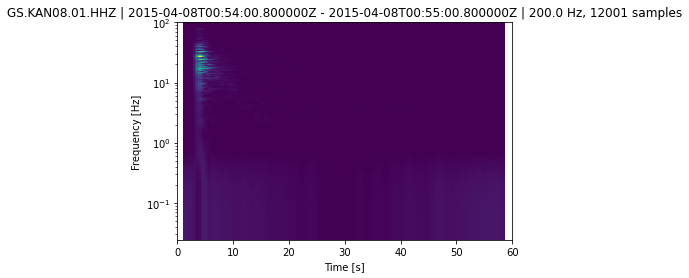

In [49]:
st[2].spectrogram(log = True)

Compression, amplitude normalization:
https://librosa.org/doc/main/generated/librosa.effects.time_stretch.html
https://superkogito.github.io/blog/rmsnormalization.html

https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html

In [50]:
#st.write('seismic_sound_test.wav',format = 'WAV',framerate = 100)

https://docs.obspy.org/tutorial/code_snippets/filtering_seismograms.html

In [51]:
base_seismogram  = st[2]

In [52]:
filtered_seismogram = st[2].filter("highpass", freq=0.5)


In [53]:
st[2].filter("highpass", freq=0.5).data.shape
#.spectrogram(log = True)

(12001,)

from pydub import AudioSegment
from pydub.playback import play

song = AudioSegment.from_wav("seismic_sound_test002.wav")
play(song)


<ipython-input-54-8528c0c08f10>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log10(Sxx))


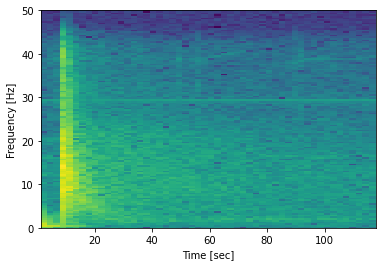

In [54]:
from scipy import signal

f, t, Sxx = signal.spectrogram(st[2].filter("highpass", freq=0.5).data, 100)
plt.pcolormesh(t, f, np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

filtered_spectrogram = plt
#plt.savefig
#plt.show()

<ipython-input-55-704b77e9e683>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  type(plt.pcolormesh(t, f, np.log10(Sxx)))


matplotlib.collections.QuadMesh

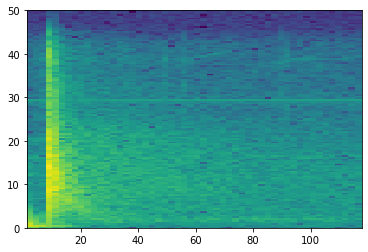

In [55]:
type(plt.pcolormesh(t, f, np.log10(Sxx)))

In [56]:
Sxx.shape

(129, 53)

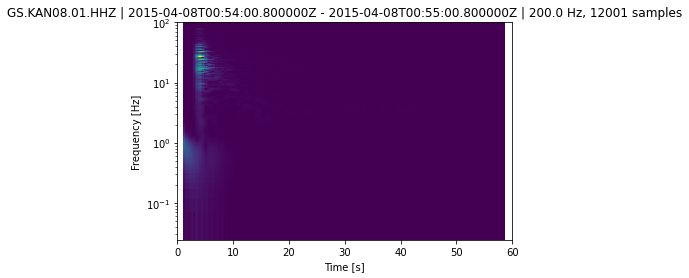

In [57]:
seis_spectrogram = st[2].filter("highpass", freq=0.5).spectrogram(log = True)

In [58]:
from io import BytesIO
import base64
def fig_to_uri(in_fig, close_all=True, **save_args):
    # type: (plt.Figure) -> str
    """
    Save a figure as a URI
    :param in_fig:
    :return:
    """
    out_img = BytesIO()
    in_fig.savefig(out_img, format='png', **save_args)
    if close_all:
        in_fig.clf()
        plt.close('all')
    out_img.seek(0)  # rewind file
    encoded = base64.b64encode(out_img.read()).decode("ascii").replace("\n", "")
    #return encoded
    return "data:image/png;base64,{}".format(encoded)

In [59]:
from io import BytesIO
import base64
from scipy import signal
def spectrogram_to_uri(input_data, close_all=True, **save_args):    
    f, t, Sxx = signal.spectrogram(input_data.filter("highpass", freq=0.5).data, 100)
    plt.pcolormesh(t, f, np.log10(Sxx))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')


    # type: (plt.Figure) -> str
    """
    Save a figure as a URI
    :param in_fig:
    :return:
    """
    out_img = BytesIO()
    plt.savefig(out_img, format='png', **save_args)
    if close_all:
        plt.clf()
        plt.close('all')
    out_img.seek(0)  # rewind file
    encoded = base64.b64encode(out_img.read()).decode("ascii").replace("\n", "")
    #return encoded
    return "data:image/png;base64,{}".format(encoded)

In [60]:
import matplotlib.pyplot as plt

In [61]:
filtered_spectrogram.savefig('test_specgram.png')

<Figure size 432x288 with 0 Axes>

plt.plot(ee[:,2])

E,N,Z channels

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

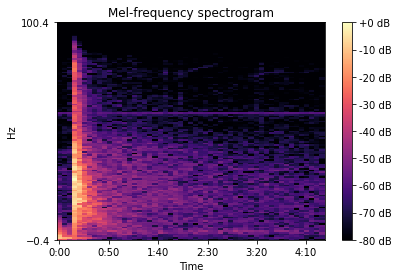

In [62]:
import librosa
import librosa.display
#TODO: convert to spectrogram
fig, ax = plt.subplots()
#S = librosa.feature.melspectrogram(y=ee[:,1], sr=100, n_mels=128,fmax=50)

#S_dB = librosa.power_to_db(np.abs(S), ref=np.max)
#S_dB = librosa.power_to_db(np.abs(librosa.stft(y=ee[:,0])), ref=np.max)
S_dB = librosa.power_to_db(np.abs(Sxx), ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                               y_axis='mel', sr=100,
                               fmax=100, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [63]:
filtered_spectrogram = fig

In [64]:
df_test['time'] = pd.to_datetime(df_test['trace_start_time'], infer_datetime_format=True)
df_test['source_depth_km'] = pd.to_numeric(df_test['source_depth_km'],errors='coerce')
df_test['source_magnitude'] = pd.to_numeric(df_test['source_magnitude'],errors='coerce')
#df_test['source_magnitude'].sort_values()
#df_test.head(2)

In [65]:
#df_test = df_test[['time','source_depth_km','source_magnitude','trace_name','source_latitude','source_longitude','trace_category']]
df_test = df_test[['time','source_depth_km','source_magnitude','source_latitude','source_longitude','trace_category']]

In [66]:
#from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="geoapiExercises")
def create_event_infos(x):
    #'time','source_depth_km','source_magnitude','trace_name','source_latitude','source_longitude','trace_category'
    #selected_record = df_test.loc[x['trace_name']]
    selected_record = df_test.loc[x]
    latitude = str(selected_record['source_latitude'])
    longitude = str(selected_record['source_longitude'])
    location = geolocator.reverse(latitude + "," + longitude)

    info_dict = dict()
    info_dict['trace_name'] = x
    info_dict['location'] = location
    info_dict['latitude'] = latitude
    info_dict['longitude'] = longitude
    info_dict['event_recorded_at'] = selected_record['time']
    info_dict['earthquake_depth'] = f'{selected_record["source_depth_km"]} km'
    info_dict['earthquake_magnitude'] = f'{selected_record["source_magnitude"]} km'
    
    #return info_dict

    #return pd.DataFrame.from_dict(info_dict).to_dict('records')
    return pd.DataFrame.from_dict(info_dict, orient='index').reset_index().to_dict('records')
    #.to_dict('records')

selected_event = create_event_infos('HPC.NC_20130403221010_EV')
selected_event

In [67]:
df_test.head(5).to_dict('records')

[{'time': Timestamp('2013-04-03 22:10:11.730000'),
  'source_depth_km': 4.72,
  'source_magnitude': 1.9,
  'source_latitude': 37.19483,
  'source_longitude': -121.478,
  'trace_category': 'earthquake_local'},
 {'time': Timestamp('2013-04-04 02:59:57.870000'),
  'source_depth_km': 4.72,
  'source_magnitude': 0.7,
  'source_latitude': 36.96383,
  'source_longitude': -121.45567,
  'trace_category': 'earthquake_local'},
 {'time': Timestamp('2013-04-05 01:11:42.080000'),
  'source_depth_km': 5.3,
  'source_magnitude': 1.3,
  'source_latitude': 36.87083,
  'source_longitude': -121.302,
  'trace_category': 'earthquake_local'},
 {'time': Timestamp('2013-04-05 09:32:39.100000'),
  'source_depth_km': 5.1,
  'source_magnitude': 2.8,
  'source_latitude': 36.962,
  'source_longitude': -121.454,
  'trace_category': 'earthquake_local'},
 {'time': Timestamp('2013-04-07 00:32:03.310000'),
  'source_depth_km': 5.4,
  'source_magnitude': 0.8,
  'source_latitude': 36.93617,
  'source_longitude': -121.4265

In [74]:
df_test

,time,source_depth_km,source_magnitude,source_latitude,source_longitude,trace_category
trace_name,,,,,,
HPC.NC_20130403221010_EV,2013-04-03 22:10:11.730000,4.72,1.90,37.19483,-121.47800,earthquake_local
HPC.NC_20130404025956_EV,2013-04-04 02:59:57.870000,4.72,0.70,36.96383,-121.45567,earthquake_local
HPC.NC_20130405011141_EV,2013-04-05 01:11:42.080000,5.30,1.30,36.87083,-121.30200,earthquake_local
HPC.NC_20130405093239_EV,2013-04-05 09:32:39.100000,5.10,2.80,36.96200,-121.45400,earthquake_local
HPC.NC_20130407003202_EV,2013-04-07 00:32:03.310000,5.40,0.80,36.93617,-121.42650,earthquake_local
...,...,...,...,...,...,...
PAH.NN_20151206184041_EV,2015-12-06 18:40:42.497390,0.00,1.60,39.97890,-118.75330,earthquake_local
PAH.NN_20151206184806_EV,2015-12-06 18:48:07.362930,3.00,0.00,39.60910,-119.96240,earthquake_local
PAH.NN_20151208145127_EV,2015-12-08 14:51:28.524250,2.60,1.90,39.61660,-119.96910,earthquake_local


Extract the minimum depth, magnitude, recording times etcc

In [68]:
#Latitudes and longitudes
site_lat = df_test.source_latitude
site_lon = df_test.source_longitude
hover_desc = 'Timestamp: ' +  str(df_test.time) + '<br>Category: ' + df_test.trace_category
#hover_desc = f'Time of registration: {df_earthquake_detections.trace_start_time} <br> Category: {df_earthquake_detections.trace_category}'
#time = df_earthquake_detections.trace_start_time
#ctg =df_earthquake_detections.trace_category
#locations_name = df.text
#min timestamp
#Extract timestamp range
min_date = min(df_test['time']).date()
max_date = max(df_test['time']).date()
#Extract minimum and maximum depth
min_depth = min(df_test['source_depth_km'])
max_depth = max(df_test['source_depth_km'])
#Extract minimum and maximum magnitude
min_magnitude = min(df_test['source_magnitude'])
max_magnitude = max(df_test['source_magnitude'])

depth_space = np.linspace(start=min_depth,stop=max_depth,num=8,endpoint=True,dtype=np.float64)
magnitude_space = np.linspace(start=min_magnitude,stop=max_magnitude,num=8,endpoint=True,dtype=np.float64)

In [73]:
df_test.columns

Index(['time', 'source_depth_km', 'source_magnitude', 'source_latitude',
       'source_longitude', 'trace_category'],
      dtype='object')

In [88]:
df_points = df_test.reset_index()[['trace_name','source_latitude','source_longitude']].head(30)
df_points_records_renamed = df_points.rename(columns = {'source_latitude' :'lat','source_longitude' :'lon'}).to_dict('records')

In [89]:
import dash_leaflet.express as dlx  

data_points_geojson = dlx.dicts_to_geojson(df_points_records_renamed) 

In [69]:
#df_earthquake_detections


Select multiple elements?
#https://github.com/thedirtyfew/dash-leaflet/issues/45

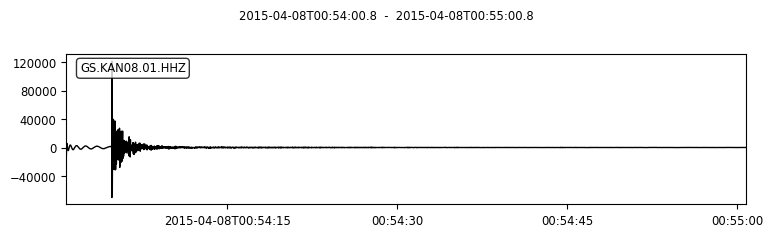

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


<ipython-input-59-36ae01439e34>:6: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



In [93]:
import base64
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px

import dash_bootstrap_components as dbc
#from dash import  dash_table
import dash_table
from datetime import date
from dash.dependencies import Input,Output,State
from dash import callback_context
from geopy.geocoders import Nominatim
import dash_leaflet as dl
geolocator = Nominatim(user_agent="geoapiExercises")
#https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scattermapbox.html
#https://community.plotly.com/t/scattermapbox-setting-visible-range/6140/3
#mapbox_access_token = open(".mapbox_token").read()

'''
mapbox_access_token = "pk.eyJ1IjoiZG9yYW5kMzIiLCJhIjoiY2t6OG81a3lnMHhnNjJ2czhkaTg2cGRreiJ9.50gnwHchu58S-KeK0fW8Ig"
#Mapbox map initialize


fig = go.Figure({"layout": {
    "title": "My Dash Graph",
    "height": 700,  # px
}})
fig.add_trace(go.Scattermapbox(
    lat=site_lat,
    lon=site_lon,
    mode='markers',
    marker=go.scattermapbox.Marker(
        #TODO: size might be affected by strength of the event
        size=17,
        #TODO: if we have other events which differs from local earthquake, other color would be assigned
        color='rgb(255, 0, 0)',
        opacity=0.7
    ),
    text=hover_desc,
    #hoverinfo='text'
    #hovertemplate=f'<i>Average Stage</i>: %{time}'+
    #              '<br><b>Average Discharge</b>: %{ctg}<br>',
    hoverinfo='text'
))
fig.update_layout(
    title='Idea for plotting earthquake events',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=38,
            lon=-94
        ),
        pitch=0,
        zoom=1,
        #minzoom = 1,
        style='light'
    ),
)
#df = px.data.gapminder().query("year == 2007")
'''
info_colnames = ['trace_name','location','latitude','longitude','event_recorded_at','earthquake_depth','earthquake_magnitude']
#info_colnames = ['trace_name','latitude','longitude','event_recorded_at','earthquake_depth','earthquake_magnitude']
def create_event_infos(x):
    #'time','source_depth_km','source_magnitude','trace_name','source_latitude','source_longitude','trace_category'
    #selected_record = df_test.loc[x['trace_name']]
    selected_record = df_test.loc[x]
    latitude = str(selected_record['source_latitude'])
    longitude = str(selected_record['source_longitude'])
    location = geolocator.reverse(latitude + "," + longitude).address

    info_dict = dict()
    info_dict['trace_name'] = x
    info_dict['location'] = location
    info_dict['latitude'] = latitude
    info_dict['longitude'] = longitude
    info_dict['event_recorded_at'] = str(selected_record['time'])
    info_dict['earthquake_depth'] = f'{selected_record["source_depth_km"]} km'
    info_dict['earthquake_magnitude'] = f'{selected_record["source_magnitude"]} km'
    
    #return info_dict

    #return pd.DataFrame.from_dict(info_dict).to_dict('records')
    #return pd.DataFrame.from_dict(info_dict, orient='index').transpose().to_dict('records')
    return pd.DataFrame.from_dict(info_dict, orient='index').reset_index().to_dict('records')
    
    


#!!!!!!!!!!!!!https://github.com/Coding-with-Adam/Dash-by-Plotly/blob/master/Dash_Interactive_Graphs/Scatter_mapbox/recycling.py
app = dash.Dash()
data_points_geojson

image_filename = 'samples_for_wireframe/map_screenshot.PNG'
encoded_image = base64.b64encode(open(image_filename, 'rb').read())
#app.layout =html.Div([
app.layout = html.Div([dbc.Row([

                                #Filters|
                                html.Div(style={'width':'20%','marginLeft': 5, 'marginRight': 10,'display':'inline-block',"border":"2px black solid",'vertical-align': 'top'},
                                         children = [
                                            #html.Div([
                                            # dcc.Graph: maybe define somehow here?
                                            #dcc.Graph(figure=fig, id='map-layout')]),
                                             #'width':'15%','marginLeft': 20, 'marginRight': 20,
                                            html.Div(style={ 'display': 'block','vertical-align':'middle'},
                                                     children = [
                                                        html.Br(),
                                                        html.H3('Select a date interval'),
                                                        html.Br(),
                                                    #Datepicker to filter for intervals
                                                        dcc.DatePickerRange(
                                                            id='date-filter',
                                                            #min_date_allowed=date(1993, 1, 10),
                                                            min_date_allowed=min_date,
                                                            max_date_allowed=max_date,
                                                            #max_date_allowed=date(2019, 9, 19),
                                                            initial_visible_month=min_date,
                                                            start_date=min_date,
                                                            end_date=max_date
                                                        )]),
                                            #'width':'15%','marginLeft': 20, 'marginRight': 20,'marginTop':30,
                                            html.Div(
                                                style={ 'display': 'block','vertical-align':'middle'},
                                                children = [
                                                html.Br(),
                                                html.H3('Select earthquake depth interval ( in km)'),
                                                html.Br(),
                                                #slider to filter for depth
                                                dcc.RangeSlider(min = min_depth, max = max_depth,
                                                                id='depth-slider',
                                                                marks={i: '{:.2f}'.format(i) for i in depth_space},
                                                                value=[min_depth, max_depth],
                                                                dots=False,
                                                                #step=
                                                                step=0.01,
                                                                updatemode='drag',
                                                                tooltip={"placement": "bottom", "always_visible": False}
                                            )]),
                                             #'width':'15%','marginLeft': 20, 'marginRight': 20,'marginTop':30,
                                            html.Div(
                                                style={'display': 'block','vertical-align':'middle'},
                                                children = [
                                                html.Br(),
                                                html.H3('Select earthquake magnitude interval ( in km)'),
                                                html.Br(),
                                                #slider to filter for magnitudes
                                                dcc.RangeSlider(min = min_magnitude, max = max_magnitude,
                                                                id='magnitude-slider',
                                                                marks={i: '{:.2f}'.format(i) for i in magnitude_space},
                                                                value=[min_magnitude, max_magnitude],
                                                                dots=False,
                                                                step=0.01,
                                                                updatemode='drag',
                                                                tooltip={"placement": "bottom", "always_visible": False}
                                                                ),
                                                ]),
                                             html.Div(
                                                 style={'display': 'block','vertical-align':'middle'},
                                                 children = [
                                                             html.Button('Apply Filter', id='filter-apply-btn', n_clicks=0),
                                                             html.Button('Reset Filter', id='filter-reset-btn', n_clicks=0)]
                                             )
                                         ]),
                                #Map
                                html.Div(
                                        style={'width':'75%', 'marginRight': 5,'display':'inline-block',"border":"2px black solid"},
                                        #children = [dcc.Graph(figure=fig, id='map-layout')])]
                                        #children = [html.Img(src ='data:image/png;base64,{}'.format(encoded_image.decode()))])]
                                        children = [dl.Map([dl.TileLayer()
                                        ,dl.GeoJSON(data = data_points_geojson)
                                        ], style={'width': '1000px', 'height': '500px'})])]
                                        #, style={'width': '1000px', 'height': '500px'})])]
                                        #children = [ dash_table.DataTable(data = df_test.head(5).to_dict('records'),columns=[{"name": i, "id": i} for i in df_test.columns], id='tbl')])]
                                ),
                dbc.Row(html.Div([
                    #Audio player
                    html.Div(style={'width':'40%','marginLeft': 5,'marginTop': 20, 'marginRight': 20,'display':'inline-block',"border":"2px black solid",'vertical-align': 'top'},
                             #children = [html.Audio(src='/assets/test_raw_waveform_normalized.wav', controls=True)]),
                             #children = [html.Audio(html.Source(src=f"https://file-examples-com.github.io/uploads/2017/11/file_example_WAV_1MG.wav",
                           #type="audio/wav"), controls=True)]),
                           children = [
                           html.Audio(html.Source(src=f'/assets/test_raw_waveform_normalized_upsampled.wav',type='audio/wav'), controls=True),                        
                                      dash_table.DataTable(style_header={'display':'none'},data = create_event_infos('HPC.NC_20130403221010_EV'),columns=[{"name": i, "id": i} for i in ['index','0']])]),
                           #dash_table.DataTable(data = create_event_infos('HPC.NC_20130403221010_EV'),columns=[{"name": i, "id": i} for i in info_colnames], id='event_info_tbl')]),
#                           ]),
                                    #,dash_table.DataTable(data = create_event_infos('HPC.NC_20130403221010_EV'),columns=[{"name": i, "id": i} for i in info_colnames], id='event_info_tbl')]),

                    #Spectrogram
                    html.Div(style={'width':'50%', 'marginRight': 10 ,'marginTop': 20, 'display':'inline-block',"border":"2px black solid"},
                             #children = [html.Img(src='samples_for_wireframe/img.png')])]))])
                             children = [
                                         html.Div(style={ 'display': 'block','vertical-align':'middle'},id = 'seismogram-div', children = [html.Img(src = fig_to_uri(base_seismogram.plot()))]),
                                         #html.Div(style={ 'display': 'block','vertical-align':'middle'},id = 'filtered_seismogram-div', children = [html.Img(src = fig_to_uri(filtered_seismogram.plot()))]),
                                         html.Div(style={ 'display': 'block','vertical-align':'middle'},id = 'spectrogram-div', children = [html.Img(src = spectrogram_to_uri(st[2]))])
                                         #html.Div(style={ 'display': 'block','vertical-align':'middle'},id = 'spectrogram-div', children = [html.Img(src = fig_to_uri(filtered_spectrogram))])                                                                                                                        
                                        ])]))
                #,dbc.Row(html.Div(children = [html.Div(style={ 'display': 'block','vertical-align':'middle'},
                #                              children = [dash_table.DataTable(style_header={'display':'none'},data = create_event_infos('HPC.NC_20130403221010_EV'),columns=[{"name": i, "id": i} for i in ['index','0']])])]))                                    
                                              #children = [dash_table.DataTable(data = create_event_infos('HPC.NC_20130403221010_EV'),columns=[{"name": i, "id": i} for i in ['index','0']])])]))                                    
                                              #children = [dash_table.DataTable(data = df_test.head(1).to_dict('records'),columns=[{"name": i, "id": i} for i in df_test.columns])])]))                                    
                    ])

@app.callback(
    #Output(component_id='tbl', component_property='data'), #Output will be the table (later map)
    Output(component_id='depth-slider', component_property= 'value'),
    Output(component_id='magnitude-slider', component_property= 'value'),
    Output(component_id='date-filter', component_property= 'start_date'),
    Output(component_id='date-filter', component_property= 'end_date'),
    Input(component_id='filter-apply-btn', component_property='n_clicks'), #Input button triggers the callback
    Input(component_id='filter-reset-btn', component_property='n_clicks'), #Input button triggers the callback
    State(component_id='depth-slider', component_property= 'value'),
    State(component_id='magnitude-slider', component_property= 'value'),
    State(component_id='date-filter', component_property= 'start_date'),
    State(component_id='date-filter', component_property= 'end_date')

)
def apply_filter(apply_click,reset_click, depth_value, magnitude_value,start_date,end_date):
    ctx = dash.callback_context
    clicked_element = ctx.triggered[0]['prop_id'].split('.')[0]
    if  clicked_element == 'filter-apply-btn':
        filter_records = df_test['time'].between(pd.to_datetime(start_date),pd.to_datetime(end_date)) & df_test['source_magnitude'].between(magnitude_value[0],magnitude_value[1])\
                         & df_test['source_depth_km'].between(depth_value[0],depth_value[1])
        df_filtered = df_test[filter_records]
        return [depth_value,magnitude_value,start_date,end_date]
        #return [df_filtered.head(5).to_dict('records'),depth_value,magnitude_value,start_date,end_date]

    elif clicked_element == 'filter-reset-btn':
        return [[min_depth,max_depth],[min_magnitude,max_magnitude],min_date,max_date]
       # return [df_test.head(5).to_dict('records'),[min_depth,max_depth],[min_magnitude,max_magnitude],min_date,max_date]

    else:
        return dash.no_update


'''
selection of earthquake events on maps
First, selection in the table will be used as test for composition,
then refactor for map event selection
'''

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter


In [ ]:
create_event_infos('HPC.NC_20130403221010_EV')

[{'index': 'trace_name', 0: 'HPC.NC_20130403221010_EV'},
 {'index': 'location',
  0: 'Rock House Ridge Trail, Santa Clara County, California, United States'},
 {'index': 'latitude', 0: '37.19483'},
 {'index': 'longitude', 0: '-121.478'},
 {'index': 'event_recorded_at', 0: '2013-04-03 22:10:11.730000'},
 {'index': 'earthquake_depth', 0: '4.72 km'},
 {'index': 'earthquake_magnitude', 0: '1.9 km'}]

In [ ]:
df_test.columns

Index(['time', 'source_depth_km', 'source_magnitude', 'source_latitude',
       'source_longitude', 'trace_category'],
      dtype='object')

If we also want to load map, that need to be used

import pydub
from pydub import AudioSegment
AudioSegment.converter = r"C:/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"
AudioSegment.ffmpeg = 'C:/ffmpeg-master-latest-win64-gpl/bin'

#"/absolute/path/to/ffmpeg"
sound_data = AudioSegment.from_file('assets/test_raw_waveform_normalized.wav', 
                                  format = "wav")

In [ ]:
[{"name": i, "id": i} for i in df_test.columns]

[{'name': 'time', 'id': 'time'},
 {'name': 'source_depth_km', 'id': 'source_depth_km'},
 {'name': 'source_magnitude', 'id': 'source_magnitude'},
 {'name': 'source_latitude', 'id': 'source_latitude'},
 {'name': 'source_longitude', 'id': 'source_longitude'},
 {'name': 'trace_category', 'id': 'trace_category'}]

In [ ]:
[{"name": i, "id": i} for i in info_colnames]

[{'name': 'trace_name', 'id': 'trace_name'},
 {'name': 'location', 'id': 'location'},
 {'name': 'latitude', 'id': 'latitude'},
 {'name': 'longitude', 'id': 'longitude'},
 {'name': 'event_recorded_at', 'id': 'event_recorded_at'},
 {'name': 'earthquake_depth', 'id': 'earthquake_depth'},
 {'name': 'earthquake_magnitude', 'id': 'earthquake_magnitude'}]

In [ ]:
eefos = create_event_infos('HPC.NC_20130403221010_EV')

[{"name": i, "id": i} for i in eefos.columns]

AttributeError: 'list' object has no attribute 'columns'

In [ ]:
selected_record = df_test.loc['HPC.NC_20130403221010_EV']
latitude = str(selected_record['source_latitude'])
longitude = str(selected_record['source_longitude'])
location_test = geolocator.reverse(latitude + "," + longitude)

In [ ]:
location_test.address

'Rock House Ridge Trail, Santa Clara County, California, United States'

In [ ]:
df_test.head(1).to_dict('records')

[{'time': Timestamp('2013-04-03 22:10:11.730000'),
  'source_depth_km': 4.72,
  'source_magnitude': 1.9,
  'source_latitude': 37.19483,
  'source_longitude': -121.478,
  'trace_category': 'earthquake_local'}]

In [ ]:
eefos

[{'trace_name': 'HPC.NC_20130403221010_EV',
  'location': Location(Rock House Ridge Trail, Santa Clara County, California, United States, (37.196515102546805, -121.47592066738518, 0.0)),
  'latitude': '37.19483',
  'longitude': '-121.478',
  'event_recorded_at': '2013-04-03 22:10:11.730000',
  'earthquake_depth': '4.72 km',
  'earthquake_magnitude': '1.9 km'}]

In [ ]:
eefos